In [ ]:
'''
    多因子选股：聚类+择时
    给出需要执行策略的时间区间以及本金，就可以自动对沪深300股票池进行kmeans聚类并且轮动
    
    based on Jupyter Notebook  
    version：python3.6
    liuhuanshuo：huanshuo0801@Gmail.com
    Apr,27,2018
'''

In [ ]:
from sklearn.cluster import KMeans
import pandas as pd
import time
import os
from pandas.core.frame import DataFrame
import tushare as ts
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [ ]:
def riqi(begin,end):
    '''
    将输入的开始和结束时间经过筛选给出需要进行轮动的时间区间
    时间已经人工处理过，在原始文件后分别添加三列buy end select记录当天状态
    '''
    print('--------正在计算时间区间---------')
    a = pd.read_excel('/Users/liuhuanshuo/Desktop/pool_date_new.xlsx') #读取经过处理的时间文件 
    
    k = 0
    
    for i in range(327): 
        '转换时间格式'
        a.ix[k,0] = a.ix[k,0].strftime("%Y-%m-%d")
        k = k+1
    
    s = list(a['日期']).index(begin) #提取开始时间的索引
    p = list(a['日期']).index(end)   #提取结束时间的索引
    a.ix[s,2] = 'F' #修改第一天的end为FALSE 这天不卖出
    a.ix[p,3] = 'F' #修改最后一天的select为FALSE 这天不计算
    t = a[s:p+1].reset_index(drop=True) #计算begin和end之间的交易日
    t = t.fillna(0)  #对空值填充0 方便之后处理
    return t

In [ ]:
def cluster(jisuanriqi):
    '''用于计算轮动时间内每最后一个交易日的聚类出的股票
       接受一个参数
       jisuanriqi为需要计算的整个时间区间
     '''
    print('--------正在聚类---------')
    b = ts.get_hs300s()
    vv = []
    dd = pd.DataFrame(columns = ['code','date','open','close'])
    for o in jisuanriqi['日期']:
        daima = pd.DataFrame(columns = ['code','open','close','ma5','ma10','v_ma10','turnover','volume','p_change'])
        for i in b['code']:
            try:
                s = ts.get_hist_data(i,start=o,end=o)
                s.insert(0,'code',i)
                s = s.loc[:,['code','open','close','ma5','ma10','v_ma10','turnover','volume','p_change']]
                daima = daima.append(s,ignore_index=True)
            except:
                pass
        daima.insert(1,'date',o)
        data = daima.loc[:,['ma5','ma10','v_ma10','turnover','volume','p_change']]
        k = 9 #聚类的类别
        iteration = 500 #聚类最大循环次数
        data = data
        data_zs = 1.0*(data - data.mean())/data.std() #数据标准化
        model = KMeans(n_clusters = k, n_jobs = 9, max_iter = iteration) #分为k类, 并发数9
        model.fit(data_zs) #开始聚类
        #简单打印结果
        r1 = pd.Series(model.labels_).value_counts() #统计各个类别的数目
        r2 = pd.DataFrame(model.cluster_centers_) #找出聚类中心
        r = pd.concat([r2, r1], axis = 1) #横向连接(0是纵向), 得到聚类中心对应的类别下的数目
        r.columns = list(data.columns) + [u'类别数目'] #重命名表头
        print(r)

        #详细输出原始数据及其类别
        r = pd.concat([data, pd.Series(model.labels_, index = data.index)], axis = 1)  #详细输出每个样本对应的类别
        r.columns = list(data.columns) + [u'聚类类别'] #重命名表头
        r



        tsne = TSNE()
        tsne.fit_transform(data_zs) #进行数据降维
        tsne = pd.DataFrame(tsne.embedding_, index = data_zs.index) #转换数据格式
        plt.rcParams['font.sans-serif'] = ['SimHei'] #用来正常显示中文标签
        plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号
        #不同类别用不同颜色和样式绘图
        d = tsne[r[u'聚类类别'] == 0]
        plt.plot(d[0], d[1], 'r.')
        d = tsne[r[u'聚类类别'] == 1]
        plt.plot(d[0], d[1], 'bo')
        d = tsne[r[u'聚类类别'] == 2]
        plt.plot(d[0], d[1], 'b*')
        d = tsne[r[u'聚类类别'] == 3]
        plt.plot(d[0], d[1], 'g+')
        d = tsne[r[u'聚类类别'] == 4]
        plt.plot(d[0], d[1], 'y+')
        d = tsne[r[u'聚类类别'] == 5]
        plt.plot(d[0], d[1], 'b+')
        d = tsne[r[u'聚类类别'] == 6]
        plt.plot(d[0], d[1], 'b^')
        d = tsne[r[u'聚类类别'] == 7]
        plt.plot(d[0], d[1], 'r^')
        d = tsne[r[u'聚类类别'] == 8]
        plt.plot(d[0], d[1], 'g^')
        plt.show()

        t= r.loc[:,'聚类类别']
        daima.insert(10,'聚类类别',t)
        cc = daima[(daima.聚类类别 == 7)]
        cc = cc.reset_index(drop=True)
        ee = cc.loc[:,['code','date','open','close']]
        dd = dd.append(ee,ignore_index=True)
        xx = len(ee)
        vv.append(xx)
    
    temp = dd
    return temp,vv

In [5]:
def mairuriqi(goumaidaima,t,vv):
    '''
    用于计算整个轮动期间的购买日的股票信息
    '''
    print('--------正在计算所有买入日期---------')
    mairuriqi = t[t['buy'] == 'T'] 
    mairude = []
    y = 0
    k = 0
    temp3 = pd.DataFrame(columns = ['code','date','open','close'])
    for i in mairuriqi['日期']:
        temp5 = pd.DataFrame(columns = ['code','date','open','close'])
        for file in goumaidaima[y:vv[k]].code:
            excel_path = os.path.join('/Users','liuhuanshuo','desktop','zuoye','lianghua','策略/') + file + '.csv'
            df = pd.read_csv(excel_path) 
            df_one = df.loc[:,['code','date','open','close']]    #提取指定列
            a = df_one[(df_one.date == i)]  #选择特定行
            temp3 = temp3.append(a,ignore_index=True)
            temp5 = temp5.append(a,ignore_index=True)
        w = len(temp5)
        mairude.append(w)
        y = y + k
        k = k + 1
    print(temp3)
    return temp3,mairude

In [6]:
def maichudaima(goumaidaima,t,vv):
    '''
    用于计算整个轮动期间需要进行卖出股票时间的股票信息
    '''
    print('--------正在计算所有卖出日期---------')
    mairuriqi = t[t['end'] == 'T'] 
    maichude = []
    y = 0
    k = 0
    temp2 = pd.DataFrame(columns = ['code','date','open','close'])
    for i in mairuriqi['日期']:
        temp5 = pd.DataFrame(columns = ['code','date','open','close'])
        for file in goumaidaima[y:vv[k]].code:
            excel_path = os.path.join('/Users','liuhuanshuo','desktop','zuoye','lianghua','策略/') + file + '.csv'
            df = pd.read_csv(excel_path) 
            df_one = df.loc[:,['code','date','open','close']]    #提取指定列
            a = df_one[(df_one.date == i)]  #选择特定行
            temp2 = temp2.append(a,ignore_index=True)
            temp5 = temp5.append(a,ignore_index=True)
        w = len(temp5)
        maichude.append(w)
        y = y + k
        k = k + 1
    print(temp2)
    return temp2,maichude

In [7]:
def zhengchang(goumaidaima,t,vv):
    '''
    用于计算整个轮动期间的无需进行操作时间的股票信息
    '''
    print('--------正在计算所有无操作日期---------')
    zhengchang = t[t['buy'] == 0]
    zhengchang = zhengchang.reset_index(drop=True)
    maichu = t[t['end'] == 'T']
    maichu = maichu.reset_index(drop=True)
    zhengchangde = []
    y = 0
    k = 0
    temp4 = pd.DataFrame(columns = ['code','date','open','close'])
    for i in zhengchang['日期']:
        temp5 = pd.DataFrame(columns = ['code','date','open','close'])
        for j in maichu['日期'][k]:
            if i < j:
                for file in goumaidaima[y:vv[k]].code:
                    excel_path = os.path.join('/Users','liuhuanshuo','desktop','zuoye','lianghua','策略/') + file + '.csv'
                    df = pd.read_csv(excel_path) 
                    df_one = df.loc[:,['code','date','open','close']]    #提取指定列
                    a = df_one[(df_one.date == i)]  #选择特定行
                    temp4 = temp4.append(a,ignore_index=True)
                    temp5 = temp5.append(a,ignore_index=True)
                w = len(temp5)
                zhengchangde.append(w)
                y = y + k
                break
    print(temp4)
    return temp4,zhengchangde

In [8]:
def lundong(t,temp2,temp3,temp4,mairude,maichude,zhengchangde):
    '''
    轮动
    接受四个参数：所有交易日期，购买日期，卖出日期，无操作日期
    在购买日期 将可用资金平均分给每个股票 以开盘价格买入
    在卖出日期 以收盘价卖出全部股票
    在无操作日期 只需更新股票价值
    
    '''
    
    keyongzijin = cash #可用资金为cash
    chigujiazhi = 0 #初始持股价值为0
    keyongzijin_1 = [] #空列表用于每次更新可用价值，下同
    chigujiazhi_1 = []
    chigushuliang = []  #创建空列表存储持股数量
    pp = 0
    kk = 0
    gg = 0
    tt = 0  #mairude里面的
    cc = 0  #maichude里面的
    zz = 0  #zhengchangde里面的
    print('--------正在轮动中，初始资金为：{0}---------'.format(keyongzijin))
    for i in range(len(t)):

        if (t.ix[i,1] == 'T' and t.ix[i,2] == 'F'):
            print('第{0}个交易日买入'.format(i))
            goumaizijin = keyongzijin/mairude[tt] #购买每只股票的资金，平均分配

            for l in range(mairude[tt]):
                chigushuliang_1 = (goumaizijin/temp3.ix[l+pp,2])
                chigushuliang.append(chigushuliang_1)

            keyongzijin = 0 #第一次卖完变成0
            chigujiazhi = goumaizijin * mairude[tt]
            pp = pp + mairude[tt]
            tt = tt + 1
            keyongzijin_1.append(keyongzijin) #将本次结果添加进储存列表
            chigujiazhi_1.append(chigujiazhi)

        elif (t.ix[i,1] == 'F' and t.ix[i,2] == 'T'):
            print('第{0}个交易日卖出'.format(i))
            chigujiazhi = 0
            chucunzijin = []
            for y in range(maichude[cc]):
                keyongzijin_2 = chigushuliang[y] * temp2.ix[y+kk,3]
                chucunzijin.append(keyongzijin_2)
            kk = kk + maichude[cc]
            cc = cc + 1
            keyongzijin = sum(chucunzijin)
            keyongzijin_1.append(keyongzijin)
            chigujiazhi_1.append(chigujiazhi)

        elif (t.ix[i,1] == 0 and t.ix[i,2] == 0 and t.ix[i,3] == 0):
            print('第{0}个交易日，无操作'.format(i))
            xianyoujiazhi = []
            for z in range(zhengchangde[zz]):
                xianyoujiazhi_1 = chigushuliang[z] * temp4.ix[z + gg,3]
                xianyoujiazhi.append(xianyoujiazhi_1)
            gg = gg + zhengchangde[zz]
            chigujiazhi = sum(xianyoujiazhi)
            keyongzijin_1.append(keyongzijin)
            chigujiazhi_1.append(chigujiazhi)
        else:
            keyongzijin_1.append(keyongzijin)
            chigujiazhi_1.append(chigujiazhi)

    c={"可用资金" : keyongzijin_1,
       "持股价值" : chigujiazhi_1}
    data1=DataFrame(c)
    data1.insert(0,'日期',t['日期'])
    data1['总资产'] = data1['可用资金'] + data1['持股价值'] #计算总资产
    
    return data1

In [9]:
def huitu(data):
    '''
    接受最终结果，并绘图
    '''
    import matplotlib.pyplot as plt 
    import matplotlib.font_manager as fm
    myfont = fm.FontProperties(fname = '/Library/Fonts/Arial Unicode.ttf') #设置中文字体 https://www.zhihu.com/question/25404709/answer/67672003
    %matplotlib inline
    x = data.loc[:,['日期']]
    y = data.loc[:,['总资产']]
    plt.style.use('ggplot') #使用ggplot风格
    plt.plot(x,y)
    plt.xlabel('时间',fontproperties = myfont)
    plt.ylabel('资产',fontproperties = myfont)
    plt.title('策略图',fontproperties = myfont)

In [10]:
def jisuan(begin,end):
    
    t = riqi(begin,end) #获得日期
    print(t)
    jisuanriqi = t[t['select'] == 'T'] #选择计算日期
    jisuanriqi = jisuanriqi.reset_index(drop=True)
    (goumaidaima,vv) = cluster(jisuanriqi)
    (temp3,mairude) = mairuriqi(goumaidaima,t,vv)
    (temp2,maichude) = maichudaima(goumaidaima,t,vv)
    (temp4,zhengchangde) = zhengchang(goumaidaima,t,vv)
    
    data = lundong(t,temp2,temp3,temp4,mairude,maichude,zhengchangde)
    huitu(data)
    return data


--------正在计算时间区间---------
           日期 buy end select
0  2016-04-01   F   F      T
1  2016-04-05   T   F      F
2  2016-04-06   0   0      0
3  2016-04-07   0   0      0
4  2016-04-08   F   T      T
5  2016-04-11   T   F      F
6  2016-04-12   0   0      0
7  2016-04-13   0   0      0
8  2016-04-14   0   0      0
9  2016-04-15   F   T      F
--------正在聚类---------
http://www.csindex.com.cn/uploads/file/autofile/closeweight/000300closeweight.xls


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  del sys.path[0]


        ma5      ma10    v_ma10  turnover    volume  p_change  类别数目
0 -0.527995 -0.531726  0.710640 -0.245350  0.626493  0.114273    50
1  1.984474  2.020591 -0.666318  0.342665 -0.699588 -0.763800    12
2  1.688393  1.628930 -0.529152  5.482800 -0.330664  2.440535     4
3 -0.345840 -0.346822  2.153151  0.717106  1.522489 -0.369694    17
4 -0.334149 -0.336777 -0.366576 -0.239822 -0.378048  0.050567    98
5  0.420313  0.430406 -0.655998 -0.226775 -0.666843 -0.552160    60
6 -0.719139 -0.729500  3.895620 -0.367720  4.980416  0.978915     3
7  7.607027  7.495028 -0.769401  1.487136 -0.689848 -0.297911     2
8 -0.545297 -0.557481  0.444731  1.324496  2.286930  3.686819     7


/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


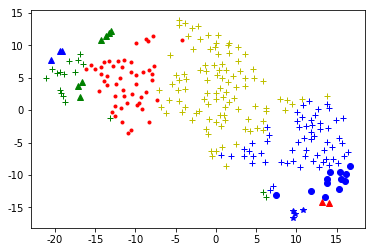

        ma5      ma10    v_ma10  turnover    volume  p_change  类别数目
0  0.920297  0.932767 -0.823071 -0.285776 -0.786297  0.104617    35
1 -0.544644 -0.547123  0.876773 -0.277132  0.660175 -0.036942    52
2  9.180289  9.322274 -0.953468 -0.641494 -0.903816 -0.379410     1
3 -0.257761 -0.254926 -0.355133 -0.200135 -0.373834 -0.540918    76
4 -0.209956 -0.210563 -0.467380 -0.326497 -0.447039  0.707582    54
5  4.649954  4.555228 -0.758337  3.694087 -0.430163 -2.335474     3
6 -0.463124 -0.472998  2.864641  0.656138  2.758927 -0.579719    12
7  0.995717  0.977251  0.095103  2.757237  0.035273 -0.425964    11
8 -0.247827 -0.252231  0.541760  1.435013  2.406989  3.364632     6


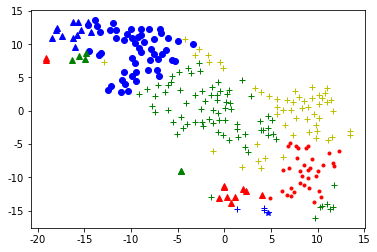

--------正在计算所有买入日期---------
      code        date    open   close
0   600519  2016-04-05  243.00  245.59
1     2466  2016-04-05  170.29  168.81
2   600519  2016-04-11  250.50  243.73
3     2466  2016-04-11  169.20  168.91
4   600074  2016-04-11   15.93   16.09
5   600570  2016-04-11   60.10   58.72
6   601198  2016-04-11   26.90   26.30
7     2027  2016-04-11   32.83   33.60
8     2074  2016-04-11   38.99   38.59
9     2292  2016-04-11   38.35   38.06
10    2460  2016-04-11   60.48   59.34
11    2601  2016-04-11   61.35   61.15
12  300024  2016-04-11   62.40   61.73
--------正在计算所有卖出日期---------
      code        date    open   close
0   600519  2016-04-08  252.00  249.86
1     2466  2016-04-08  169.00  167.00
2   600519  2016-04-15  242.64  244.95
3     2466  2016-04-15  163.00  163.34
4   600074  2016-04-15   16.11   16.41
5   600570  2016-04-15   59.95   60.16
6   601198  2016-04-15   27.36   26.98
7     2027  2016-04-15   34.23   33.95
8     2074  2016-04-15   37.21   36.84
9     22

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:57: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: DeprecationWarning: 
.ix is deprecated. Please use
.loc for la

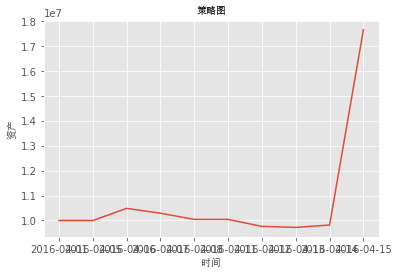

In [12]:
begin ='2016-04-01'
end = '2016-04-15'
cash = 10000000
result = jisuan(begin,end)

In [13]:
result

,日期,可用资金,持股价值,总资产
0,2016-04-01,1.000000e+07,0.000000e+00,1.000000e+07
1,2016-04-05,0.000000e+00,1.000000e+07,1.000000e+07
2,2016-04-06,0.000000e+00,1.048715e+07,1.048715e+07
3,2016-04-07,0.000000e+00,1.029123e+07,1.029123e+07
4,2016-04-08,1.004455e+07,0.000000e+00,1.004455e+07
5,2016-04-11,0.000000e+00,1.004455e+07,1.004455e+07
6,2016-04-12,0.000000e+00,9.762510e+06,9.762510e+06
7,2016-04-13,0.000000e+00,9.722516e+06,9.722516e+06
8,2016-04-14,0.000000e+00,9.818307e+06,9.818307e+06
9,2016-04-15,1.766349e+07,0.000000e+00,1.766349e+07
